## 목차
### 1. Library Import
### 2. 학습데이터 생성
### 3. Light-gbm 모델 훈련
### 4. 교차 검증 점수 확인
### 5. 제출 파일 생성

# 1. Library Import

In [ ]:
import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/', nb_path) 
sys.path.insert(0, nb_path)

Drive already mounted at /content/mnt; to attempt to forcibly remount, call drive.mount("/content/mnt", force_remount=True).


FileExistsError: ignored

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import tensorflow as tf
import string

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Activation, Dropout, Flatten, Dense,Softmax, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import warnings
warnings.filterwarnings(action='ignore')





# 필요한 함수 정의
def make_datetime(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    #print("x="+x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    hour  = int(x[8:10])
    #print(year,month,day,hour)
    #mim  = int(x[10:12])
    #sec  = int(x[12:])
    return dt.datetime(year, month, day, hour) #20201130190653

def string2num(x):
    # (,)( )과 같은 불피요한 데이터 정제
    x = re.sub(r"[^0-9]+", '', str(x))
    if x =='':
        return 0
    else:
        return int(x)

PATH='/content/mnt/MyDrive/Colab Notebooks/'
#PATH = '/content/'

In [ ]:
!ls /content/mnt/MyDrive/'Colab Notebooks'/


'시스템_품질 저하로 인한 사용자 불편 예지 AI 경진대회 BASELINE.ipynb'
'AI경진대회 pro.ipynb'
 almostfinisheddeeperlayer.ipynb
 archive.zip
 imagetransform.ipynb
 sample_submission.csv
't81_558_class_06_3_resnet.ipynb의 사본'
 test_err_data.csv
 test_quality_data.csv
 train_err_data.csv
 train_problem_data.csv
 train_quality_data.csv
 Untitled0.ipynb
 Untitled1.ipynb


# 2. 학습 데이터 생성

## 2.1 train_err

* train_err_data.csv 파일의 errtype column의 value_counts를 카운트하여 학습에 사용.  
* 주어진 기간동안 user_id별로 peroblem가 한 번이라도 발생했는 지를 확인.  

In [ ]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
display(train_err.head())

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [ ]:
# 데이터 설명을 확인하면
# ueser_id가 10000부터 24999까지 총 15000개가 연속적으로 존재.
display(train_err.head())
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0


In [ ]:
print(np.sort(train_err.errtype.unique()))
print(train_err.errtype.unique().max() - \
      train_err.errtype.unique().min() +1)
# errtype이 1부터 42까지 총 42개가 연속적으로 존재.

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 30 31 32 33 34 35 36 37 38 39 40 41 42]
42


In [ ]:
# user_id와 errtype만을 사용하여 데이터 셋 생성
# 모든 일자에 대해서 errtype별 발생 건수를 count
# pandas의 groupby를 활용할 경우 큰 연산 자원이 필요.
# numpy로 placeholder를 만들어 구현함.
import copy
id_error = train_err[['user_id','errtype']].values
error = np.zeros((train_user_number,42)) #15000,42 의 0배열 생성.
minnum=317
curuser=10000
errstrli=np.zeros((train_user_number,1),dtype="object")
templi=[]
tempstrli=[]
strli=[]
errli=np.empty((train_user_number,1),dtype="object")
sum=0
tempstr=""
for person_idx, err in tqdm(id_error):
    #print(person_idx)
    if (curuser==person_idx):
      templi.append(err)
      tempstr+=" "+str(err)
    else:
      errli[curuser-train_user_id_min][0]=np.array(templi)
      
      templi=[]
      templi.append(err)

      tempstrli.append(tempstr)
     # tempstrli=tempstrli[1:]
      strli.append(tempstrli)
      #print(curuser-train_user_id_min)
      errstrli[curuser-train_user_id_min]=copy.deepcopy(tempstrli)
      tempstrli=[]
      curuser=person_idx
      tempstr=""
      tempstr+=" "+str(err)
    
    # person_idx - train_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1  그래서 [사람idx,error type] 번째에 +=1 되는건데, errtype이 1~42니까 -1 해서 errtype의 min은 0번부터시작, person도 0번부터 시작
    error[person_idx - train_user_id_min,err - 1] += 1

errli[curuser-train_user_id_min][0]=np.array(templi) #마지막에는 한번 안 더해져서나와.
tempstrli.append(tempstr)
#tempstrli=tempstrli[1:]
print("tempstrl",tempstrli)
strli.append(tempstrli)
#newstrli=np.array(strli)
errstrli[curuser-train_user_id_min]=copy.deepcopy(tempstrli)
print("shape=",error.shape)
print("errli[0]=",errli[0])
print("errli.shape",errli[0].shape)
print("errli[0][0]",errli[0][0])




        

# 이말인즉슨, 1 row에 err type 0 이 몇회 발생 , 1이 몇회발생 ~~~


100%|██████████| 16554663/16554663 [01:08<00:00, 241862.46it/s]

tempstrl [' 4 4 11 12 5 4 16 26 4 15 4 16 4 15 16 15 16 15 4 16 4 15 16 4 4 15 16 4 26 4 15 16 15 4 16 4 15 4 16 4 15 12 11 13 12 3 7 6 14 14 14 14 16 4 26 4 15 4 16 4 15 16 4 4 15 16 15 16 4 26 4 15 16 4 4 15 16 15 4 16 4 15 4 16 4 15 12 11 5 16 4 26 4 15 16 15 16 15 16 15 16 4 26 4 15 4 16 4 15 16 4 4 15 12 11 4 16 26 4 15 16 15 16 15 16 4 4 15 16 15 16 4 4 15 16 15 16 4 26 4 15 16 4 4 15 16 15 16 15 16 15 16 15 16 15 12 11 4 16 26 4 15 16 4 4 15 4 16 4 15 16 15 3 13 12 7 6 14 14 14 14 14 14 4 16 26 4 15 16 4 4 15 16 4 4 15 16 15 11 12 5 4 16 26 4 15 4 16 4 15 16 4 4 15 16 4 4 15 16 15 16 4 26 4 15 16 4 4 15 16 4 4 15 16 15 4 4 12 11 5 4 16 26 4 15 16 4 4 15 16 15 16 4 4 15 16 4 4 15 16 4 26 4 15 16 15 16 15 16 4 4 15 12 11 16 4 26 4 15 16 4 4 15 16 15 16 4 4 15 4 16 26 4 15 4 16 4 4 4 15 16 4 4 15 16 4 4 15 6 4 4 11 12 5 3 13 12 6 7 14 14 14 14 16 4 26 4 15 16 4 4 15 16 15 16 4 4 15 16 4 26 4 15 16 4 4 15 16 4 4 15 16 15 11 12 5 16 4 26 4 15 16 15 16 15 16 4 4 15 4 16 26 4 15 16 4 4

In [ ]:
#print(errstrli)
#errstrli[0]=["abc is abc"]
#print(tempstrli)
#errstrli[0]=tempstrli
#print(errstrli)
#errstrli.shape

In [ ]:
#print(errstrli[0])
#[' 15 12 11 16 4 26 4 15 16 4 4 26 15 16 4 4 15 16 4 4 15 12 11 16 4 26 4 15 10 11 14 12 3 14 12 11 10 3 16 4 26 4 15 12 11 16 4 26 4 15 16 4 4 16 4 26 4 15 16 4 4 15 11 12 14 12 10 3 11 10 12 14 11 3 16 4 26 4 15 16 4 4 26 15 16 15 16 4 4 26 15 16 4 4 15 16 4 26 4 15 4 4 16 15 16 26 15 4 4 16 15 16 4 4 15 16 4 4 26 15 16 4 4 26 15 12 11 16 4 26 4 15 16 4 4 15 4 4 16 16 26 15 16 4 4 15 16 4 4 26 15 12 11 13 12 3 6 7 14 14 14 16 4 26 4 26 15 16 4 4 15 16 4 4 26 15 16 4 4 15 16 15 16 4 26 4 15 16 4 4 15 14 10 3 12 11 16 4 4 15 16 4 26 4 14 10 11 12 3 15 16 4 4 14 10 12 11 3 15 16 4 26 4 26 15 16 15 4 4 16 26 15 16 4 4 26 15 16 4 4 26 15 16 4 4 26 15 16 4 4 15 16 4 4 15 16 26 15 4 4 16 15 16 4 4 15 11 12 16 4 26 4 15 16 4 4 15 16 26 15 4 4 16 15 16 15 16 4 4 15 16 15 4 4 16 15 11 12 16 4 26 4 27 28 15 16 4 4 16 4 26 4 15 16 4 4 15']
#string으로 저장을끝냈다.
samples = np.array([["This is the 1st sample."], ["And here's the 2nd sample."]])
samples.shape
print(samples.dtype)
print(errstrli)
#print(errstrli)
#newsli=errstrli.reshape((15000,1)) #shape맞춰야해
#print(newsli.shape)
#print(newsli)
print(samples[0])
print(tempstrli)
print(np.array(tempstrli))
#errstrli[0]=np.array(tempstrli)


<U26
[[' 15 12 11 16 4 26 4 15 16 4 4 26 15 16 4 4 15 16 4 4 15 12 11 16 4 26 4 15 10 11 14 12 3 14 12 11 10 3 16 4 26 4 15 12 11 16 4 26 4 15 16 4 4 16 4 26 4 15 16 4 4 15 11 12 14 12 10 3 11 10 12 14 11 3 16 4 26 4 15 16 4 4 26 15 16 15 16 4 4 26 15 16 4 4 15 16 4 26 4 15 4 4 16 15 16 26 15 4 4 16 15 16 4 4 15 16 4 4 26 15 16 4 4 26 15 12 11 16 4 26 4 15 16 4 4 15 4 4 16 16 26 15 16 4 4 15 16 4 4 26 15 12 11 13 12 3 6 7 14 14 14 16 4 26 4 26 15 16 4 4 15 16 4 4 26 15 16 4 4 15 16 15 16 4 26 4 15 16 4 4 15 14 10 3 12 11 16 4 4 15 16 4 26 4 14 10 11 12 3 15 16 4 4 14 10 12 11 3 15 16 4 26 4 26 15 16 15 4 4 16 26 15 16 4 4 26 15 16 4 4 26 15 16 4 4 26 15 16 4 4 15 16 4 4 15 16 26 15 4 4 16 15 16 4 4 15 11 12 16 4 26 4 15 16 4 4 15 16 26 15 4 4 16 15 16 15 16 4 4 15 16 15 4 4 16 15 11 12 16 4 26 4 27 28 15 16 4 4 16 4 26 4 15 16 4 4 15']
 [' 15 15 31 33 12 11 15 22 26 16 31 26 41 5 5 5 5 5 5 5 5 5 41 14 14 14 14 14 14 16 31 31 41 15 40 16 31 40 31 34 41 15 40 16 40 31 31 15 16 31 31 40 1

In [ ]:
maxnum=0
count=0
for i in errstrli:
    count+=1
    #print(len(i[0]))
    if(maxnum<len(i[0])):
        print(count)
        maxnum=len(i[0])
print(maxnum) #최장길이 str ==635115 at 14935
print(count)
#print(len(errstrli[0][0]))

1
2
11
51
266
440
645
649
1368
5571
14935
635115
15000


In [ ]:
'''
np.min(li)
min=li[0][0]
for i in range(len(li)):
    print(i,li[i])

li2=np.zeros((train_user_number,1))

for person_idx, err in id_error:
    li2[person_idx-train_user_id_min,0]+=1
for i in range(len(li2)):
  if(li2[i]<10):
    print(i,li2[i])
'''
#print(np.min(li)) #10개보다적은 데이터는 일단안쓰는걸로하자.

'\nnp.min(li)\nmin=li[0][0]\nfor i in range(len(li)):\n    print(i,li[i])\n\nli2=np.zeros((train_user_number,1))\n\nfor person_idx, err in id_error:\n    li2[person_idx-train_user_id_min,0]+=1\nfor i in range(len(li2)):\n  if(li2[i]<10):\n    print(i,li2[i])\n'

In [ ]:
#참고) 일별 합산 데이터 생성 코드      
train_err = pd.read_csv(PATH+'train_err_data.csv')
train_err['datetime']=pd.to_datetime(train_err['time'])
#train_err['time']
#train_err['time'][0]
#print(train_err['time'])
train_err['datetime'] = train_err['time'].apply(make_datetime)
print(train_err['datetime'][0])



2020-11-01 02:00:00


In [ ]:
print(train_err['datetime'][0])
print(train_err['datetime'][10])
print(train_err['datetime'][10]-train_err['datetime'][0])

2020-11-01 02:00:00
2020-11-01 17:00:00
0 days 15:00:00


In [ ]:
'''

train_err             = pd.read_csv(PATH+'train_err_data.csv')
train_err['datetime'] = train_err['time'].apply(make_datetime)

min_day = train_err.datetime.min().date()
|
train_err['days'] = train_err.loc[:,'datetime'].dt.date - min_day
train_err['days'] = train_err['days'].dt.days
display(train_err)

id_error = train_err[['user_id','errtype','days']].values
error = np.zeros((train_user_number,42, 33))
for idx, err, days in tqdm(id_error):
    error[idx - train_user_id_min,err - 1, days] += 1  #이건 일자도 추가된거 위에거랑 똑같은데
error.shape
'''

"\n\ntrain_err             = pd.read_csv(PATH+'train_err_data.csv')\ntrain_err['datetime'] = train_err['time'].apply(make_datetime)\n\nmin_day = train_err.datetime.min().date()\n|\ntrain_err['days'] = train_err.loc[:,'datetime'].dt.date - min_day\ntrain_err['days'] = train_err['days'].dt.days\ndisplay(train_err)\n\nid_error = train_err[['user_id','errtype','days']].values\nerror = np.zeros((train_user_number,42, 33))\nfor idx, err, days in tqdm(id_error):\n    error[idx - train_user_id_min,err - 1, days] += 1  #이건 일자도 추가된거 위에거랑 똑같은데\nerror.shape\n"

## 2.2 problem

In [ ]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
# error와 동일한 방법으로 person_idx - 10000 위치에 
# person_idx의 problem이 한 번이라도 발생했다면 1
# 없다면 0   문제가 하나도 없었던 사람은 0이야.
problem[train_prob.user_id.unique()-10000] = 1   
problem.shape

(15000,)

In [ ]:
for i in range(len(problem)):
    if(problem[i])


0.0

# 2.5 validation set 만들기


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val= train_test_split(errstrli,problem, test_size=0.1,shuffle=True,random_state=1004)
print("validation set shape=",x_val.shape,y_val.shape) #1500개의 validation set

print(x_train[15],y_train[15])


validation set shape= (1500, 1) (1500,)
[' 26 15 16 31 31 15 16 31 31 31 31 15 16 31 15 16 31 23 22 15 33 15 11 12 15 22 26 16 31 15 26 16 31 31 15 16 31 31 15 15 33 15 15 11 12 15 22 26 16 31 26 15 16 31 31 15 15 33 15 22 11 12 15 26 16 31 31 31 15 16 31 31 15 16 31 31 15 26 16 31 15 16 31 15 16 31 31 31 31 15 16 31 31 23 22 23 22 15 16 31 15 40 16 40 15 16 31 15 15 33 15 22 12 11 15 16 26 31 23 22 23 22 23 22 23 22 31 31 15 16 31 31 23 22 31 31 15 16 31 31 15 16 31 31 15 40 16 40 31 31 15 15 33 15 11 12 15 22 23 22 23 22 26 16 31 15 22 26 16 31 31 15 33 15 12 11 15 22 26 16 31 15 16 31 31 23 22 15 16 31 31 15 16 40 40 31 31 15 40 16 31 40 31 15 40 16 40 31 31 23 22 23 22 23 22 26 15 16 31 31 15 16 31 31 23 22 15 16 31 31 15 23 22 15 15 33 15 12 11 15 22 26 16 31 15 16 31 15 16 31 31 31 31 31 15 16 31 31 31 31 16 26 31 31 15 16 31 31 23 22 23 22 23 22 23 22 23 22 23 22 23 22 23 22 15 16 31 31 15 16 31 31 23 22 23 22 23 22 23 22 15 15 33 15 11 12 15 22 26 16 31 15 16 31 31 23 22 15 15 

#2.6 Embedding layer만들기
The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings)
https://www.tensorflow.org/tutorials/text/word_embeddings?hl=en

즉, 각각의 error type을 dense vector로 바꿔주는 것이 
embedding layer이며, dimentionality (width) 를 조정하면서
내 문제에 잘 맞는지 확인할 수 있다.
Dense layer에 node를 몇개 둘 것인지 계속 바꿔나가는 것 과 같이.
``` python
# Embed a 1,000 word vocabulary into 5 dimensions.
embedding_layer = tf.keras.layers.Embedding(1000, 5)
```
### 방안
1. 단순하게 생각하면, 우린 42개의 error type이 있다고 볼 수 있다. 고로 42개의 error type 각각을 dense vector로 바꿔주면 되지 않을까?
고로, embedding_layer을 다음과같이만들어보자.
2. 아니면 42개의 error type이 있는건 맞지만, 되게 다양한 state에서의 error type이존재하기도 한다. 즉 1번 에러 뒤에오는 2번이라던지?
근데 경우의 수가 너무 많아지고 본래도 비슷할 것 같다
왜냐하면 word도 앞에나올수도 있고 뒤에 나올 수도 있기 때문

지금 sequence dimension이라는 것은
5 이런거. 우리가 5차원으로 뒀지.
1000개의 sequence가 있어 위 예제에는.

In [ ]:
#text encoder만들기
VOCAB_SIZE=43
encoder=tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(errstrli)
vocab=np.array(encoder.get_vocabulary())
print(vocab)
#encode를 한다면



['' '[UNK]' '23' '31' '22' '15' '4' '16' '32' '5' '40' '28' '27' '26' '12'
 '11' '14' '33' '34' '10' '41' '7' '6' '17' '24' '42' '3' '2' '13' '1'
 '39' '35' '37' '36' '38' '18' '20' '25' '19' '21' '30' '8' '9']


In [ ]:
print(errstrli[:3])
encod_ex=encoder(errstrli[:3]).numpy()
print(encod_ex)
'''
tf.Tensor(
[[ 5 14 15 ...  0  0  0]
 [ 5  5  3 ...  7  3  3]
 [15 14  7 ...  0  0  0]], shape=(3, 2365), dtype=int64)
  와 같이 encoding되어있다.
 '''


[[' 15 12 11 16 4 26 4 15 16 4 4 26 15 16 4 4 15 16 4 4 15 12 11 16 4 26 4 15 10 11 14 12 3 14 12 11 10 3 16 4 26 4 15 12 11 16 4 26 4 15 16 4 4 16 4 26 4 15 16 4 4 15 11 12 14 12 10 3 11 10 12 14 11 3 16 4 26 4 15 16 4 4 26 15 16 15 16 4 4 26 15 16 4 4 15 16 4 26 4 15 4 4 16 15 16 26 15 4 4 16 15 16 4 4 15 16 4 4 26 15 16 4 4 26 15 12 11 16 4 26 4 15 16 4 4 15 4 4 16 16 26 15 16 4 4 15 16 4 4 26 15 12 11 13 12 3 6 7 14 14 14 16 4 26 4 26 15 16 4 4 15 16 4 4 26 15 16 4 4 15 16 15 16 4 26 4 15 16 4 4 15 14 10 3 12 11 16 4 4 15 16 4 26 4 14 10 11 12 3 15 16 4 4 14 10 12 11 3 15 16 4 26 4 26 15 16 15 4 4 16 26 15 16 4 4 26 15 16 4 4 26 15 16 4 4 26 15 16 4 4 15 16 4 4 15 16 26 15 4 4 16 15 16 4 4 15 11 12 16 4 26 4 15 16 4 4 15 16 26 15 4 4 16 15 16 15 16 4 4 15 16 15 4 4 16 15 11 12 16 4 26 4 27 28 15 16 4 4 16 4 26 4 15 16 4 4 15']
 [' 15 15 31 33 12 11 15 22 26 16 31 26 41 5 5 5 5 5 5 5 5 5 41 14 14 14 14 14 14 16 31 31 41 15 40 16 31 40 31 34 41 15 40 16 40 31 31 15 16 31 31 40 15 16 

'\ntf.Tensor(\n[[ 5 14 15 ...  0  0  0]\n [ 5  5  3 ...  7  3  3]\n [15 14  7 ...  0  0  0]], shape=(3, 2365), dtype=int64)\n  와 같이 encoding되어있다.\n '

In [ ]:
print(vocab[encod_ex[0]])
print(" ".join(vocab[encod_ex[0]])) #round-trip 문장 만들은거야지금 https://www.tensorflow.org/tutorials/text/text_classification_rnn?hl=en
print(len(encoder.get_vocabulary()))


['15' '12' '11' ... '' '' '']
15 12 11 16 4 26 4 15 16 4 4 26 15 16 4 4 15 16 4 4 15 12 11 16 4 26 4 15 10 11 14 12 3 14 12 11 10 3 16 4 26 4 15 12 11 16 4 26 4 15 16 4 4 16 4 26 4 15 16 4 4 15 11 12 14 12 10 3 11 10 12 14 11 3 16 4 26 4 15 16 4 4 26 15 16 15 16 4 4 26 15 16 4 4 15 16 4 26 4 15 4 4 16 15 16 26 15 4 4 16 15 16 4 4 15 16 4 4 26 15 16 4 4 26 15 12 11 16 4 26 4 15 16 4 4 15 4 4 16 16 26 15 16 4 4 15 16 4 4 26 15 12 11 13 12 3 6 7 14 14 14 16 4 26 4 26 15 16 4 4 15 16 4 4 26 15 16 4 4 15 16 15 16 4 26 4 15 16 4 4 15 14 10 3 12 11 16 4 4 15 16 4 26 4 14 10 11 12 3 15 16 4 4 14 10 12 11 3 15 16 4 26 4 26 15 16 15 4 4 16 26 15 16 4 4 26 15 16 4 4 26 15 16 4 4 26 15 16 4 4 15 16 4 4 15 16 26 15 4 4 16 15 16 4 4 15 11 12 16 4 26 4 15 16 4 4 15 16 26 15 4 4 16 15 16 15 16 4 4 15 16 15 4 4 16 15 11 12 16 4 26 4 27 28 15 16 4 4 16 4 26 4 15 16 4 4 15                                                                                                                                      

### 2.7 layer에 넣는작업

layer에 넣으려면 errli[0]은 317개의 err type 즉, 317개의 5차원 seqeuence가 존재할테고
errli[1]은 뭐 몇개 이런식으로 존재할텐데
그 개수를 통일시키기 위해서
global Average Pooling 1D layer을 두면, 317개의 5차원 sequence들의 평균을 이용해서 둘 수 도 있고,
RNN 을 이용할 수도 있어.
일단 global Average Pooling 1D

# 3. Light-gbm 모델 훈련

In [ ]:
# 변수 이름 변경
# error  -> train_x
# problem-> train_y

train_x = error
train_y = problem
del error, problem
print(train_x.shape)
print(train_y.shape)

In [ ]:
print(train_x[0])
print(train_y[0])

In [ ]:
'''
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
'''  

model=Sequential()
model.add( Dense(42, activation='relu',input_shape=(42,)) )
model.add( Dense(42, activation='relu' ))

model.add( Dense(1,activation='softmax'))

model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(train_x,train_y,
                                             test_size=0.3, #30%만 test set으로
                                             shuffle=False,
                                             random_state=1004
                                             )

'''k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
#print(train_x)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]
    #print(X)'''

history=model.fit(x_train,y_train,epochs=10,batch_size=10,validation_data=(x_val,y_val))


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 42)                1806      
_________________________________________________________________
dense_36 (Dense)             (None, 42)                1806      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 43        
Total params: 3,655
Trainable params: 3,655
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1050/1050 [==============================] - 3s 2ms/step - loss: 668.1629 - accuracy: 0.3340 - val_loss: 0.6433 - val_accuracy: 0.3433
Epoch 2/10
1050/1050 [==============================] - 2s 2ms/step - loss: 1.5718 - accuracy: 0.3341 - val_loss: 0.6439 - val_accuracy: 0.3433
Epoch 3/10
1050/1050 [==============================] - 2s 2ms/step - loss: 0.6366 - accura

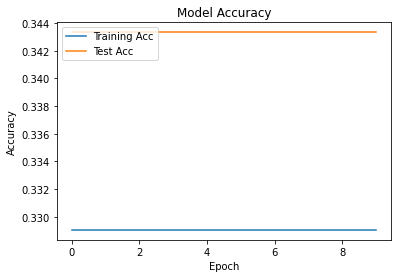

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

In [ ]:
# Train
#-------------------------------------------------------------------------------------
# validation auc score를 확인하기 위해 정의
def f_pr_auc(probas_pred, y_true):
    labels=y_true.get_label()
    p, r, _ = precision_recall_curve(labels, probas_pred)
    score=auc(r,p) 
    return "pr_auc", score, True
#-------------------------------------------------------------------------------------



models     = []
recalls    = []
precisions = []
auc_scores   = []
threshold = 0.5
# 파라미터 설정
params =      {
                'boosting_type' : 'gbdt',
                'objective'     : 'binary',
                'metric'        : 'auc',
                'seed': 1015
                }
#-------------------------------------------------------------------------------------
# 5 Kfold cross validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, val_idx in k_fold.split(train_x):

    # split train, validation set
    X = train_x[train_idx]
    y = train_y[train_idx]
    valid_x = train_x[val_idx]
    valid_y = train_y[val_idx]

    d_train= lgb.Dataset(X, y)
    d_val  = lgb.Dataset(valid_x, valid_y)
    
    #run traning
    model = lgb.train(
                        params,
                        train_set       = d_train,
                        num_boost_round = 1000,
                        valid_sets      = d_val,
                        feval           = f_pr_auc,
                        verbose_eval    = 20, 
                        early_stopping_rounds = 3
                       )
    
    # cal valid prediction
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold, 1, 0)
    
    # cal scores
    recall    = recall_score(    valid_y, valid_pred)
    precision = precision_score( valid_y, valid_pred)
    auc_score = roc_auc_score(   valid_y, valid_prob)

    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)

    print('==========================================================')

[LightGBM] [Info] Number of positive: 3633, number of negative: 8367
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4353
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.302750 -> initscore=-0.834237
[LightGBM] [Info] Start training from score -0.834237
Training until validation scores don't improve for 3 rounds
[20]	valid_0's auc: 0.797482	valid_0's pr_auc: 0.79351
Early stopping, best iteration is:
[25]	valid_0's auc: 0.800713	valid_0's pr_auc: 0.798635
[LightGBM] [Info] Number of positive: 4828, number of negative: 7172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4499
[LightGBM] [Info] Number of dat

# 4. 교차검증 점수 확인

In [ ]:
print(np.mean(auc_scores))

0.7914130199022232


# 5. 제출 파일 생성

In [ ]:
test_err  = pd.read_csv(PATH+'test_err_data.csv')
display(test_err.head())

,user_id,time,model_nm,fwver,errtype,errcode
0,30000,20201101030227,model_1,04.16.3553,31,1
1,30000,20201101030227,model_1,04.16.3553,33,2
2,30000,20201101030228,model_1,04.16.3553,15,1
3,30000,20201101030256,model_1,04.16.3553,22,1
4,30000,20201101030300,model_1,04.16.3553,11,1


In [ ]:
# 데이터 설명을 확인하면
# test 데이터는 ueser_id가 30000부터 44998까지 총 14999개가 존재.
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [ ]:
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((test_user_number,42))
for person_idx, err in tqdm(id_error):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_x[person_idx - test_user_id_min,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
print(test_x.shape)

100%|██████████████████████████████████████████████████████████████████| 16532648/16532648 [00:49<00:00, 333788.67it/s]

(14999, 42)


In [ ]:
# 예측
pred_y_list = []
for model in models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)


In [ ]:
pred_ensemble

array([[0.57755635],
       [0.26089892],
       [0.31557557],
       ...,
       [0.38301962],
       [0.61611595],
       [0.34348301]])

In [ ]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')

In [ ]:
sample_submssion['problem'] = pred_ensemble.reshape(-1)

In [ ]:
sample_submssion.to_csv("sample_submssion.csv", index = False)
sample_submssion

,user_id,problem
0,30000,0.577556
1,30001,0.260899
2,30002,0.315576
3,30003,0.535576
4,30004,0.454501
...,...,...
14994,44994,0.329001
14995,44995,0.315880
14996,44996,0.383020
14997,44997,0.616116
